# Ridge Regression

**I. Weight update steps of stochastic gradient descent (SGD) for linear regression with L2 regularisation norm.**

For loss function with L2 regularisation norm, the error function can be written as,

\begin{align}
\large{E(w) := \sum_{n} E_{n}(w) +\frac{\lambda}{2}{w^2} \small{\quad\textrm{ where }\quad} \large{E_{n}(w) := {\frac{1}{2}}(t_{n} - w^T\phi(x_{n}))^2}}
\end{align}

so the gradient can be computed as:

\begin{align*}
\large{\nabla({E_{n}}(w) + \frac{\lambda}{2}{w^2}) := \nabla({E_{n}}(w) + \nabla(\frac{\lambda}{2}{w^2})} \\
\large{:= -\phi(x_{n})(t_{n} - w^T\phi(x_{n})) +{w}{\lambda}}
\end{align*}

After presentation of the $n$th training datapoint, the stochastic gradient descent algorithm updates the parameter vector $w$ using,

\begin{align}
\large{\textbf{w}^{(\tau)} = \textbf{w}^{(\tau-1)} - {\eta}^{(\tau)}{\nabla} (E_{n}(\textbf{w}^{(\tau)})+ \frac{\lambda}{2}{\textbf{|w|}^2})}
\end{align}

where $\tau$ denotes the iteration number, and ${\eta}^{(\tau)}$is a learning rate parameter.

So the stochastic gradient learning gradient is as follows:

- Initialize the parameter $\large{\textbf{w}}$ to some starting vector $\large{\textbf{w}^{(0)}}$ and $\large{\tau = 1}$
- While stopping condition is not met do:
    - randomly select a datapoint $(x_{n}, y_{n})$ from training dataset
    - $\large{\textbf{w}^{(\tau)} := \textbf{w}^{(\tau-1)} - {\eta}^{(\tau)}{\nabla} (E_{n}(\textbf{w}^{(\tau)})+ \frac{\lambda}{2}{\textbf{|w|}^2})} \\
    \implies \large{\textbf{w}^{(\tau)} := \textbf{w}^{(\tau-1)} - {\eta}^{(\tau)}({\nabla}E_{n}(\textbf{w}^{(\tau)})+ {\lambda}{\textbf{|w|}})}$
    - $\large{\tau = \tau + 1}$


$\large{\tau}$ here refers to visiting a single training datapoint in Stochastic GD

In [78]:
# load libraries
library(ggplot2) # for plots
library(reshape2) # for data reshaping
library(repr) 
library(tidyr)

In [79]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

In [80]:
# auxiliary function to calculate labels based on the estimated coefficients

# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(.5 * (mean((predict_func(Phi, w) - label)^2)) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
    n_weights = dim(W)[1]
    errors = matrix(,nrow=n_weights, ncol=2)
    for (tau in 1:n_weights) {
        errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
        errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
    }
    return(errors)
}


In [81]:
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {
   set.seed(123)
    
   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # final value for training objective function and weights
   return(list('vals'=obj_func_val,'W'=W))
}

# update the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # add regularisation
   grad = -as.vector(y_true-y_pred) * x + lambda * W_prev
   # update weight
   updated_weight <- W_prev - eta * grad
    return (updated_weight)
}


Load training and testing data

In [82]:
# read data
train <- read_data('Data//1C_train.csv',TRUE)
test <- read_data('Data//1C_test.csv',TRUE)

In [83]:
# Initialisation

# maximum number of iteration
max_epoch <- 20 
# a threshold on the cost 
epsilon <- .001 
# learning rate
eta <- .01
#lambda
lambdas <- (0:25)*0.4

**For each lambda in {0, 0.4, 0.8, …, 10}, lets build a regression model and compute the training and testing errors.**

In [84]:
# create a table error
error.table <- data.frame(matrix(ncol = 3, nrow = 0))

for (l in lambdas) { #loop over each value of lambdas
    # training with given value of lambdas
    fit <- sgd_train(train$x, train$y, lambda = l, eta = 0.01, epsilon = 0.001, max_epoch= 20)    
    # Create dataframe to store error value
    test_error <- data.frame(0)
    
    # transform value of lambdas into log lambda
    test_error["log_lambdas"] = log(l)
    
    # get value of the last epoch
    test_error["train error"] = tail(get_errors(train, test, fit$W),1)[1]
    test_error["test error"] = tail(get_errors(train, test, fit$W),1)[2]
    
    # adding error to table error
    error.table <- rbind(error.table, test_error)
}

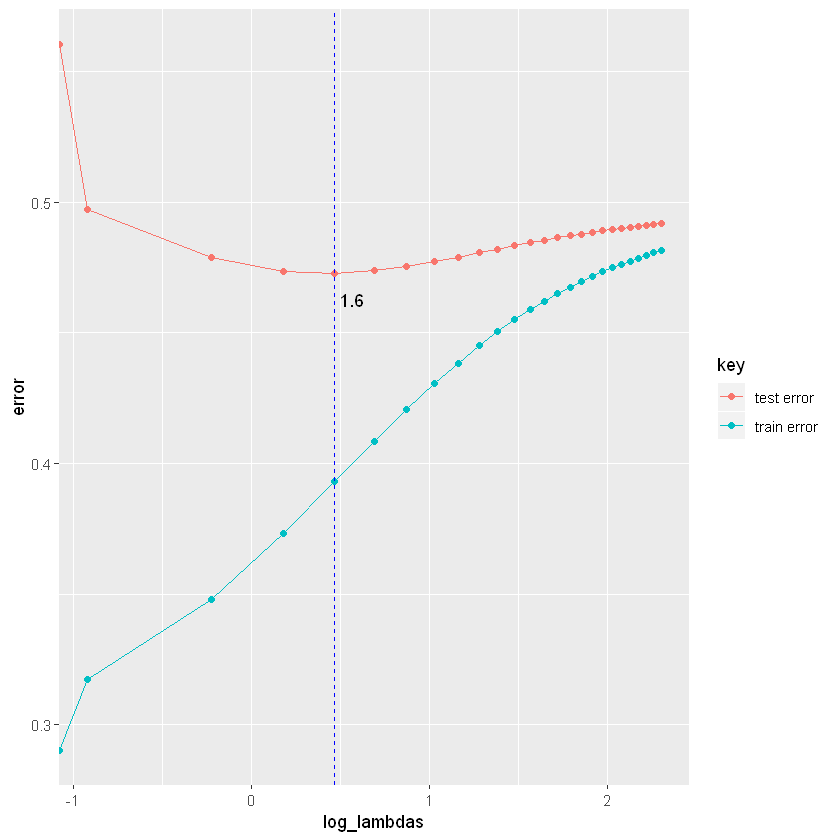

In [85]:
mintest = min(error.table["test error"]) #spotting the lowest error
# plot errors
error.table %>%
    gather(key, error ,"train error","test error") %>%
    ggplot(aes(x=log_lambdas, y = error, colour = key)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = error.table[which(error.table["test error"] == mintest),"log_lambdas"], linetype="dashed", color = "blue") +
    annotate("text", x = error.table[which(error.table["test error"] == mintest),"log_lambdas"]+0.1, y = mintest-0.01, label = exp(error.table[which(error.table["test error"] == mintest),"log_lambdas"]))
    

The best value of lambda is **1.6**

Model with higher complexity tend to be overfitting, which we can be seen when lambda=0 due to high test error and relatively low train error. As lambda increases, the model complexity decreases and we see increase in training error. This leads to making model less complex. So for larger value of lambda the model underfits (high test and high train error).

The testing error decreases to some point and then increases with inrease in value of lambda. Here when **$\lambda=1.6$** the model has least testing error hence its the best value of lambda as it is said to have generalized better at this value of $\lambda$.